# Experiments with Baseline Classifiers

I apply traditional non-neural classifiers to the test data: dummy classifier, Naive Bayes classifier, Logistic Regression, SVM and others.

In [15]:
import pandas as pd
import numpy as np
import json
import sklearn.model_selection
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB,ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay
import sklearn.feature_extraction
from sklearn.svm import SVC
from datasets import load_dataset

In [6]:
# Load the X-GENRE datasets from Hugging Face
train = load_dataset("TajaKuzman/X-GENRE-text-genre-dataset", "train")


# To open them as Pandas DataFrame:
df_train = pd.DataFrame(train["train"])

print(df_train.shape)

(1772, 4)


In [5]:
# Load the test datasets from the GitHub repositories (access to them is obtained by request to the AGILE repository owner)

en_ginco = pd.read_json("../../datasets/EN-GINCO-test-dataset/EN-GINCO.jsonl", lines=True)
x_ginco = pd.read_json("../../datasets/X-GINCO-test-set/X-GINCO.jsonl", lines=True)

print(en_ginco.shape, x_ginco.shape)

(272, 4) (790, 6)


In [17]:
en_ginco.head(1)

,text,labels,dataset,language
0,Welcome to KBismarck.org! This is a community ...,Information/Explanation,EN-GINCO,English


In [7]:
df_train.describe(include="all")

,text,labels,dataset,language
count,1772,1772,1772,1772
unique,1772,9,3,2
top,Harry Potter and the Philosopher's Stone - J. ...,News,FTD,English
freq,1,344,630,1237


In [8]:
# Create X_train and Y_train parts, used for sci kit learning
# List of texts in training split
X_train = list(df_train.text)
# List of labels in training split
Y_train = list(df_train.labels)


print(len(X_train), len(Y_train))

1772 1772


In [9]:
# Create a list of labels
labels = list(df_train.labels.unique())
labels

['Other',
 'Information/Explanation',
 'News',
 'Instruction',
 'Opinion/Argumentation',
 'Forum',
 'Prose/Lyrical',
 'Legal',
 'Promotion']

## Creating Sci-Kit classifiers

In [10]:
# Create a TF-IDF representation of the text
def data_iterator(f):
    for token in f:
        yield token


def tokenizer(txt):
    """Simple whitespace tokenizer"""
    return txt.split()

In [11]:
iterator=data_iterator(X_train)

vectorizer=sklearn.feature_extraction.text.TfidfVectorizer(tokenizer=tokenizer,use_idf=True,min_df=0.005)
d=vectorizer.fit_transform(iterator)

/home/tajak/miniconda3/envs/IPTC_env/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [12]:
# Create a pipeline of models that you want to try:

pipelines=[]

#for model in [DummyClassifier(strategy="most_frequent"), DummyClassifier(strategy="stratified"), DecisionTreeClassifier(), MultinomialNB(), ComplementNB(), LogisticRegression(), SVC(),RandomForestClassifier()]:
for model in [ComplementNB(), LogisticRegression(penalty=None), SVC(kernel="linear", C=2)]:
    pipeline=make_pipeline(model)
    pipelines.append(pipeline)

In [13]:
for i, pipeline in enumerate(pipelines):
    pipeline.fit(d, Y_train)

In [22]:
def classify(df_test, df_test_name, pipelines = pipelines):

	# List of texts in test split
	X_test = list(df_test.text)
	# List of labels in test split
	Y_test = list(df_test.labels)

	test_iterator=data_iterator(X_test)
	d_test=vectorizer.transform(test_iterator)

	print(len(X_test), len(Y_test))

	for i, pipeline in enumerate(pipelines):
		y_pred=list(pipeline.predict(d_test))
		model_name = pipelines[i].steps[0][0].upper()
		model_name = model_name.split("(")[0]

		# Create a json with results
		current_results = {
			"system": model_name,
			"predictions": [
				{
				"train": "X-GENRE (train split)",
				"test": "{}".format(df_test_name),
				"predictions": y_pred,
				}
			]
			}

		# Save the results as a new json
		with open("submissions/submission-{}-{}.json".format(model_name, df_test_name), "w") as file:
			json.dump(current_results, file)

		print("Classification with {} on {} finished.".format(model_name, df_test_name))


In [24]:
classify(en_ginco, "en-ginco", pipelines)

272 272
Classification with COMPLEMENTNB on en-ginco finished.
Classification with LOGISTICREGRESSION on en-ginco finished.
Classification with SVC on en-ginco finished.


In [25]:
classify(x_ginco, "x-ginco", pipelines)

790 790
Classification with COMPLEMENTNB on x-ginco finished.
Classification with LOGISTICREGRESSION on x-ginco finished.
Classification with SVC on x-ginco finished.


## Training FastText model

In [18]:
# Import the train file on which the classifiers will be trained - we will use the X-GENRE train dataset
df_train = pd.read_csv("data/X-GENRE-train.csv", index_col=0, sep="\t")
df_train.head(2)

,text,labels
0,"Seeking All Things Brilliant ""I want people to...",Other
1,Meet Orchid du Bois I first met Hayley Mowday ...,Other


In [20]:
# Creating FastText train and test files

def fastText_files(df_train, df_test):
    """
    This function creates and saves the test and train file.
    
    The function returns a list of the following elements:
        - labels - which can be used for prediction and evaluation.
        - train file path
        - test file path
    """
    test_df = df_test[["text", "true_label"]]
    # Rename the columns
    test_df.columns = ["text", "labels"]
    
    # Assure that the text contains no new lines
    test_df["text"] =  [text.replace("\n", "") for text in test_df.text.to_list()]
    df_train["text"] =  [text.replace("\n", "") for text in df_train.text.to_list()]

    print("The shape of the dataframes:")
    print(df_train.shape, test_df.shape)
    
    # Then create CSV files which FastText can read
    
    train_file_content=""

    for labels, text in df_train.loc[:, ["labels", "text"]].values:
        label = f"__label__{labels}"
        train_file_content += f"""{label} {text}\n"""
    
    train_path = ""
    train_path = "data/x-genre-fasttext.train"

    with open(train_path,"w") as train_file:
        train_file.write(train_file_content)
    
    train_example = open(train_path,"r").readlines()
    print("Created train file:")
    print(train_example[:2])
    print("Number of lines: {}".format(len(train_example)))
    
    test_file_content=""
    
    for labels, text in test_df.loc[:, ["labels", "text"]].values:
        label = f"__label__{labels}"
        test_file_content += f"""{label} {text}\n"""
    
    test_path = ""
    test_path = "data/test-file-fasttext.test"
    
    with open(test_path,"w") as test_file:
        test_file.write(test_file_content)
    
    test_example = open(test_path,"r").readlines()
    print("Created test file:")
    print(test_example[:2])
    print("Number of lines: {}".format(len(test_example)))
    
    # Finally, create a list of labels which can be used for prediction and evaluation.
    # Let's inspect the labels:
    all_df_labels = df_train["labels"].unique().tolist()
    
    for i in test_df["labels"].unique().tolist():
        if i not in all_df_labels:
            all_df_labels.append(i)

    print(f"Number of all labels: {len(all_df_labels)}")
    
    # Create a final list of labels in a FastText-appropriate format:
    LABELS = df_train.labels.unique().tolist()
    LABELS = [f"__label__{i}" for i in LABELS]
    
    return_list = [LABELS, train_path, test_path]
    print(f"The function returned the following list: {return_list}")
    
    return return_list

fasttext_dict = fastText_files(df_train, df_test)

print(fasttext_dict)

The shape of the dataframes:
(1772, 2) (864, 2)
Created train file:
['__label__Other Seeking All Things Brilliant "I want people to become curious about the stories that abound in their neighborhoods and cities. I want to create a \'culture of honour\' where we are all intentional about pulling out the good, the noble, the beautiful around us." I first met Jenn Co on Robson Street where my friend Keela and I interviewed her for a national documentary about church decline. Dressed like a fashion frontrow champ, she was articulate beyond our wildest hopes and savvy to boot. I liked her immediately. Fast forward seven years and she\'s the same, except brighter and bolder, if that is even possible. While Jenn\'s charted a course as a fashion stylist for years, today she\'s producing Anything Brilliant , a pilot television show that celebrates good wherever she can find it. It was a sitdown with footware magnate John Fluevog that led to her current trajectory. "I went to this church, uTown,

/tmp/ipykernel_4144296/1035929600.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["text"] =  [text.replace("\n", "") for text in test_df.text.to_list()]


In [27]:
def prediction_to_label(prediction):
    """Transforms predictions as returned by fasttext into pure labels."""
    return np.array(prediction[0])[:, 0]

# Parsing test file
def parse_test_file(path: str):
    """Reads fasttext formatted file and returns labels, texts."""
    with open(path, "r") as f:
        content = f.readlines()
    pattern = "{label} {text}\n"
    p = parse.compile(pattern)

    labels, texts = list(), list()
    for line in content:
        rez = p.parse(line)
        if rez is not None:
            labels.append(rez["label"])
            texts.append(rez["text"])
        else:
            print("error parsing line ", line)
    return labels, texts

# Train fasttext model   
model = ft.train_supervised(input="data/x-genre-fasttext.train",
                            epoch = 350,
                            wordNgrams=1,
                            verbose = 2
                                        )

Read 1M words
Number of words:  163798
Number of labels: 9
Progress: 100.0% words/sec/thread:  145067 lr:  0.000000 avg.loss:  0.178346 ETA:   0h 0m 0s


I experimented with epochs and used 350 epochs.

In [28]:
# Parse the test files so that labels and texts are separated
y_true, y_texts = parse_test_file("data/test-file-fasttext.test")

# Evaluate the model on test data
y_pred = model.predict(y_texts)
y_pred = prediction_to_label(y_pred)

y_pred = [x.replace("__label__", "") for x in y_pred]

# Add the y_pred to the test_df
df_test["FastText"] = y_pred

## Evaluating the models

In [4]:
# Import the test df with results
df_test = pd.read_csv("data/main_test_file_with_predictions-additional-baseline-classifiers.csv", index_col = 0)
df_test.head(2)

,text,true_label,id,dataset,truncated_texts,true_label_forChatGPT,gpt-3.5-turbo,mt0,text_prompts,mt0_xl,X-GENRE,X-GENRE-confidence,dummy-classifier-stratified,nb-complement,logistic-regression,svc,FastText
0,Welcome to KBismarck.org! This is a community ...,Information/Explanation,en_ginco_0,EN-GINCO,Welcome to KBismarck.org! This is a community ...,Information,Forum,Forum,Please classify the following text according t...,Forum,Forum,"[('Forum', 0.9329903455731817), ('Other', 0.05...",Information/Explanation,Instruction,Opinion/Argumentation,Promotion,Promotion
1,Why graft thrives in postconflict zones <p> A ...,News,en_ginco_1,EN-GINCO,Why graft thrives in postconflict zones <p> A ...,News,News,Opinion,Please classify the following text according t...,World politics,News,"[('News', 0.9989983760338668), ('Instruction',...",News,Information/Explanation,News,News,News


In [13]:
df_test.columns

Index(['text', 'true_label', 'id', 'dataset', 'truncated_texts',
       'true_label_forChatGPT', 'gpt-3.5-turbo', 'mt0', 'text_prompts',
       'mt0_xl', 'X-GENRE', 'X-GENRE-confidence',
       'dummy-classifier-stratified', 'nb-complement', 'logistic-regression',
       'svc', 'FastText'],
      dtype='object')

In [5]:
# Let's test the performance on EN-GINCO, X-GENRE and different splits of X-GENRE
def test_splits(model):
    en_ginco_df = df_test[df_test["dataset"] == "EN-GINCO"]
    print("Performance on EN-GINCO")
    print(en_ginco_df.shape)

    y_true = en_ginco_df["true_label"].to_list()
    y_pred = en_ginco_df[model].to_list()
    labels = list(en_ginco_df["true_label"].unique())

    results_en_ginco = testing(y_true, y_pred, labels)

    x_genre_df = df_test[df_test["dataset"] != "EN-GINCO"]
    print("Performance on X-GENRE (entire)")
    print(x_genre_df.shape)

    y_true = x_genre_df["true_label"].to_list()
    y_pred = x_genre_df[model].to_list()
    labels = list(x_genre_df["true_label"].unique())

    results_x_genre = testing(y_true, y_pred, labels)

    x_genre_en_df = x_genre_df[x_genre_df["dataset"] != 'X-GENRE-test-GINCO']
    print("Performance on X-GENRE (English part)")
    print(x_genre_en_df.shape)

    y_true = x_genre_en_df["true_label"].to_list()
    y_pred = x_genre_en_df[model].to_list()
    labels = list(x_genre_en_df["true_label"].unique())

    results_x_genre_en = testing(y_true, y_pred, labels)

    x_genre_sl_df = x_genre_df[x_genre_df["dataset"] == 'X-GENRE-test-GINCO']
    print("Performance on X-GENRE (Slovene part)")
    print(x_genre_sl_df.shape)

    y_true = x_genre_sl_df["true_label"].to_list()
    y_pred = x_genre_sl_df[model].to_list()
    labels = list(x_genre_sl_df["true_label"].unique())

    results_x_genre_sl = testing(y_true, y_pred, labels)

    return {"en-ginco":results_en_ginco, "x-genre":results_x_genre, "x-genre-en":results_x_genre_en, "x-genre-sl": results_x_genre_sl}

In [6]:
en_ginco_all_results = {}
x_genre_all_results = {}
x_genre_en_all_results = {}
x_genre_sl_all_results = {}

dummy-classifier-stratified
Performance on EN-GINCO
(272, 17)
Macro f1: 0.0981, Micro f1: 0.136
Accuracy: 0.136


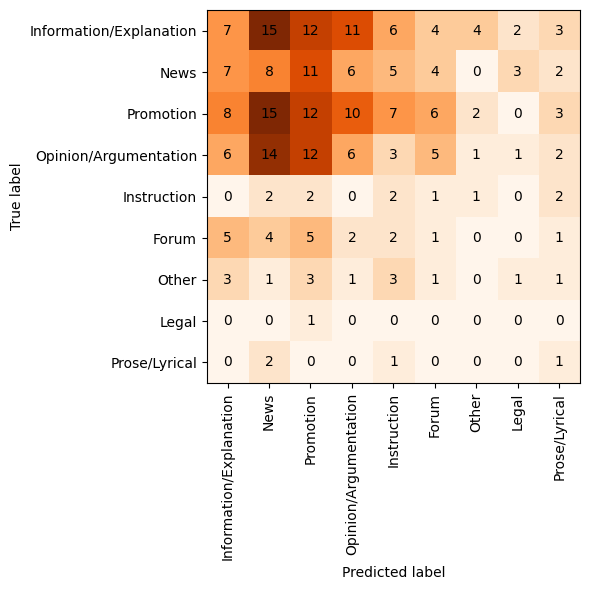

                         precision    recall  f1-score   support

Information/Explanation       0.05      0.05      0.05        20
                   News       0.19      0.11      0.14        64
              Promotion       0.07      0.20      0.10        10
  Opinion/Argumentation       0.00      0.00      0.00         1
            Instruction       0.13      0.17      0.15        46
                  Forum       0.17      0.12      0.14        50
                  Other       0.00      0.00      0.00        14
                  Legal       0.21      0.19      0.20        63
          Prose/Lyrical       0.07      0.25      0.11         4

               accuracy                           0.14       272
              macro avg       0.10      0.12      0.10       272
           weighted avg       0.15      0.14      0.14       272

Performance on X-GENRE (entire)
(592, 17)
Macro f1: 0.0925, Micro f1: 0.128
Accuracy: 0.128


<Figure size 640x480 with 0 Axes>

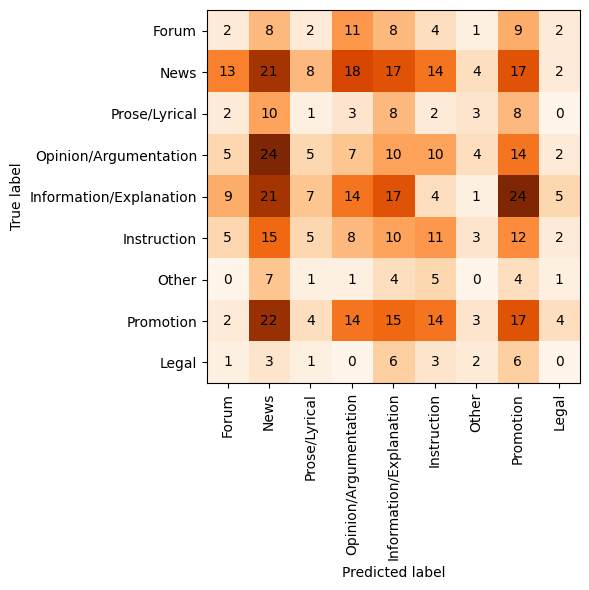

                         precision    recall  f1-score   support

                  Forum       0.05      0.04      0.05        47
                   News       0.18      0.17      0.17       102
          Prose/Lyrical       0.16      0.15      0.16        71
  Opinion/Argumentation       0.00      0.00      0.00        22
Information/Explanation       0.16      0.18      0.17       114
            Instruction       0.09      0.09      0.09        81
                  Other       0.00      0.00      0.00        23
              Promotion       0.15      0.18      0.17        95
                  Legal       0.03      0.03      0.03        37

               accuracy                           0.13       592
              macro avg       0.09      0.09      0.09       592
           weighted avg       0.12      0.13      0.13       592

Performance on X-GENRE (English part)
(413, 17)
Macro f1: 0.0962, Micro f1: 0.133
Accuracy: 0.133


<Figure size 640x480 with 0 Axes>

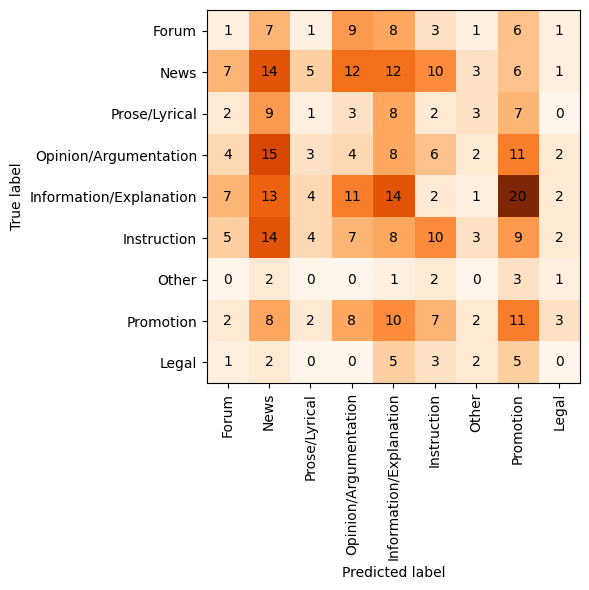

                         precision    recall  f1-score   support

                  Forum       0.03      0.03      0.03        37
                   News       0.19      0.19      0.19        74
          Prose/Lyrical       0.22      0.16      0.19        62
  Opinion/Argumentation       0.00      0.00      0.00        18
Information/Explanation       0.17      0.20      0.18        70
            Instruction       0.07      0.07      0.07        55
                  Other       0.00      0.00      0.00         9
              Promotion       0.14      0.21      0.17        53
                  Legal       0.05      0.03      0.04        35

               accuracy                           0.13       413
              macro avg       0.10      0.10      0.10       413
           weighted avg       0.13      0.13      0.13       413

Performance on X-GENRE (Slovene part)
(179, 17)
Macro f1: 0.0806, Micro f1: 0.117
Accuracy: 0.117


<Figure size 640x480 with 0 Axes>

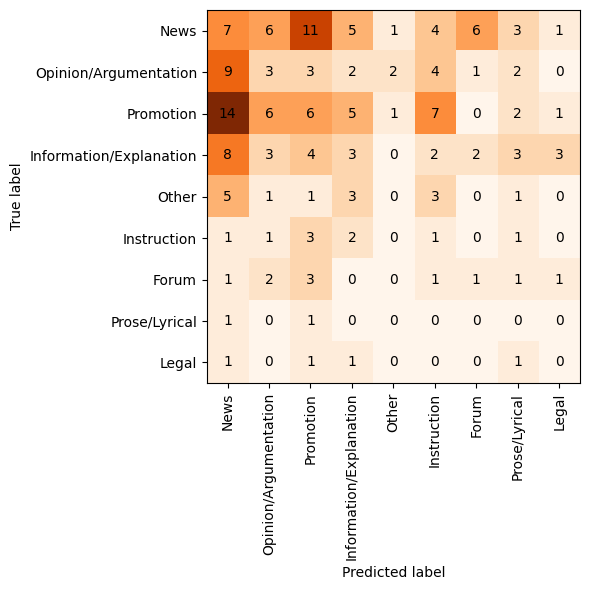

                         precision    recall  f1-score   support

                   News       0.10      0.10      0.10        10
  Opinion/Argumentation       0.14      0.11      0.12        28
              Promotion       0.05      0.11      0.06         9
Information/Explanation       0.00      0.00      0.00         4
                  Other       0.15      0.16      0.15        44
            Instruction       0.14      0.12      0.12        26
                  Forum       0.00      0.00      0.00        14
          Prose/Lyrical       0.18      0.14      0.16        42
                  Legal       0.00      0.00      0.00         2

               accuracy                           0.12       179
              macro avg       0.08      0.08      0.08       179
           weighted avg       0.13      0.12      0.12       179

nb-complement
Performance on EN-GINCO
(272, 17)
Macro f1: 0.289, Micro f1: 0.36
Accuracy: 0.36


<Figure size 640x480 with 0 Axes>

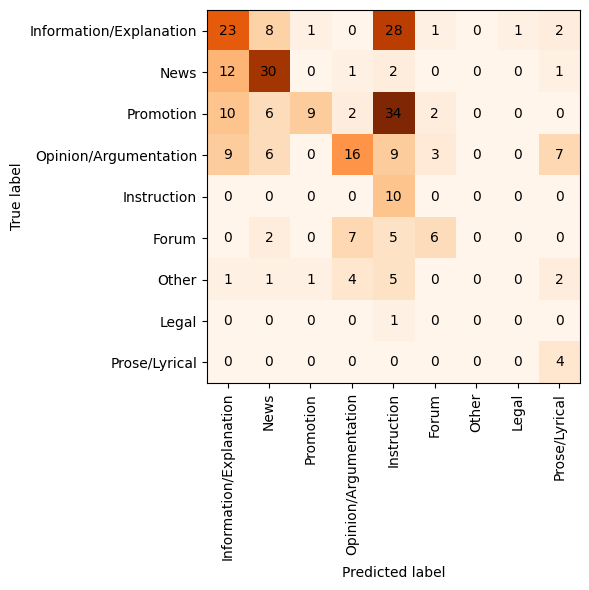

                         precision    recall  f1-score   support

Information/Explanation       0.50      0.30      0.37        20
                   News       0.42      0.36      0.39        64
              Promotion       0.11      1.00      0.19        10
  Opinion/Argumentation       0.00      0.00      0.00         1
            Instruction       0.57      0.65      0.61        46
                  Forum       0.53      0.32      0.40        50
                  Other       0.00      0.00      0.00        14
                  Legal       0.82      0.14      0.24        63
          Prose/Lyrical       0.25      1.00      0.40         4

               accuracy                           0.36       272
              macro avg       0.35      0.42      0.29       272
           weighted avg       0.53      0.36      0.36       272

Performance on X-GENRE (entire)
(592, 17)
Macro f1: 0.518, Micro f1: 0.557
Accuracy: 0.557


/home/tajak/Classification-with-ChatGPT/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/Classification-with-ChatGPT/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/Classification-with-ChatGPT/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

<Figure size 640x480 with 0 Axes>

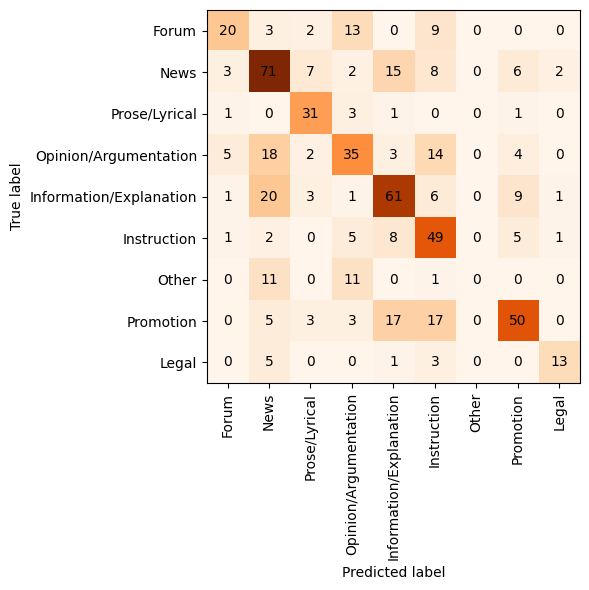

                         precision    recall  f1-score   support

                  Forum       0.65      0.43      0.51        47
                   News       0.58      0.60      0.59       102
          Prose/Lyrical       0.46      0.69      0.55        71
  Opinion/Argumentation       0.76      0.59      0.67        22
Information/Explanation       0.53      0.62      0.57       114
            Instruction       0.48      0.43      0.45        81
                  Other       0.00      0.00      0.00        23
              Promotion       0.67      0.53      0.59        95
                  Legal       0.65      0.84      0.73        37

               accuracy                           0.56       592
              macro avg       0.53      0.52      0.52       592
           weighted avg       0.55      0.56      0.54       592

Performance on X-GENRE (English part)
(413, 17)
Macro f1: 0.543, Micro f1: 0.6
Accuracy: 0.6


/home/tajak/Classification-with-ChatGPT/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/Classification-with-ChatGPT/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/Classification-with-ChatGPT/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

<Figure size 640x480 with 0 Axes>

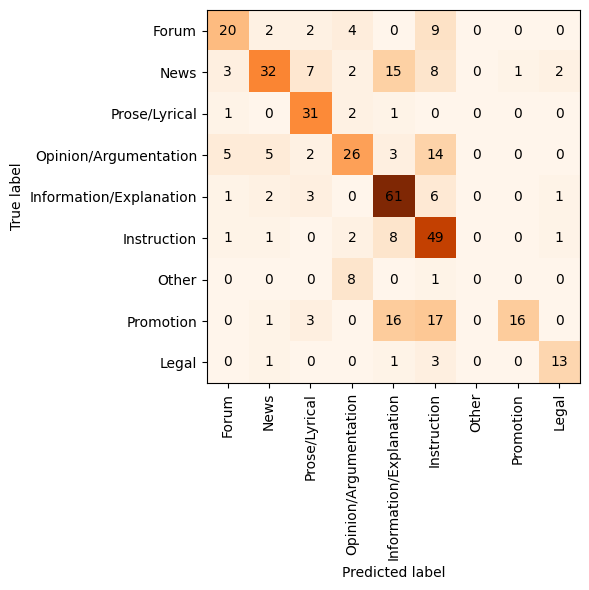

                         precision    recall  f1-score   support

                  Forum       0.65      0.54      0.59        37
                   News       0.58      0.82      0.68        74
          Prose/Lyrical       0.46      0.79      0.58        62
  Opinion/Argumentation       0.76      0.72      0.74        18
Information/Explanation       0.73      0.46      0.56        70
            Instruction       0.59      0.47      0.53        55
                  Other       0.00      0.00      0.00         9
              Promotion       0.94      0.30      0.46        53
                  Legal       0.65      0.89      0.75        35

               accuracy                           0.60       413
              macro avg       0.59      0.55      0.54       413
           weighted avg       0.64      0.60      0.58       413

Performance on X-GENRE (Slovene part)
(179, 17)
Macro f1: 0.176, Micro f1: 0.458
Accuracy: 0.458


/home/tajak/Classification-with-ChatGPT/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/Classification-with-ChatGPT/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/Classification-with-ChatGPT/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

<Figure size 640x480 with 0 Axes>

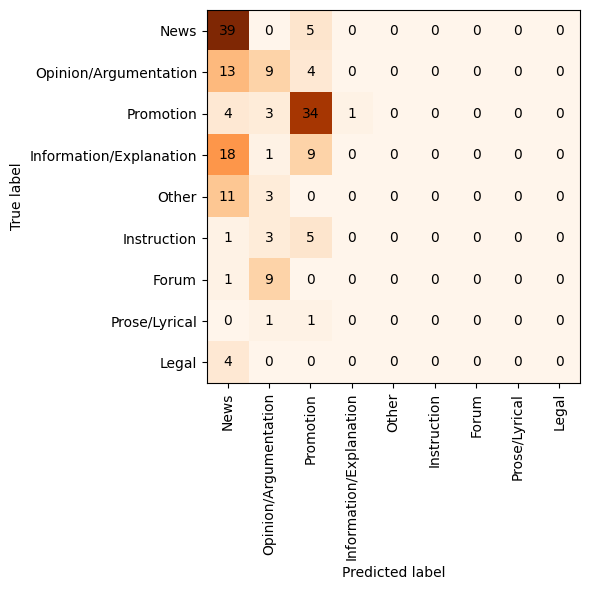

                         precision    recall  f1-score   support

                   News       0.00      0.00      0.00        10
  Opinion/Argumentation       0.00      0.00      0.00        28
              Promotion       0.00      0.00      0.00         9
Information/Explanation       0.00      0.00      0.00         4
                  Other       0.43      0.89      0.58        44
            Instruction       0.31      0.35      0.33        26
                  Forum       0.00      0.00      0.00        14
          Prose/Lyrical       0.59      0.81      0.68        42
                  Legal       0.00      0.00      0.00         2

               accuracy                           0.46       179
              macro avg       0.15      0.23      0.18       179
           weighted avg       0.29      0.46      0.35       179

logistic-regression
Performance on EN-GINCO
(272, 17)
Macro f1: 0.47, Micro f1: 0.489
Accuracy: 0.489


/home/tajak/Classification-with-ChatGPT/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/Classification-with-ChatGPT/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/Classification-with-ChatGPT/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

<Figure size 640x480 with 0 Axes>

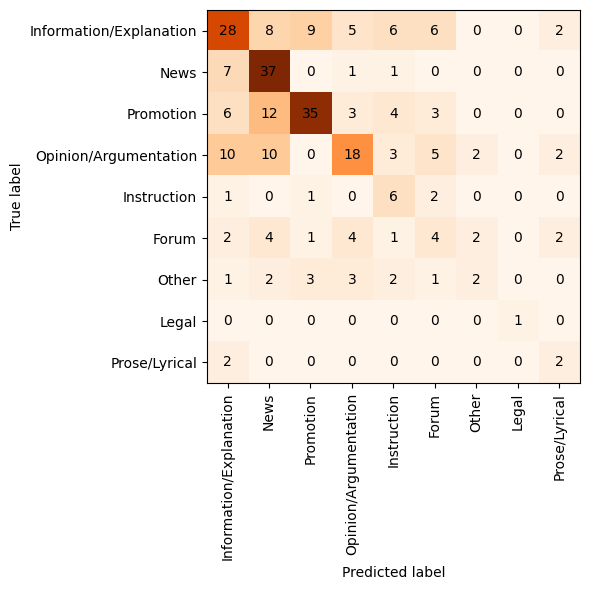

                         precision    recall  f1-score   support

Information/Explanation       0.19      0.20      0.20        20
                   News       0.49      0.44      0.46        64
              Promotion       0.26      0.60      0.36        10
  Opinion/Argumentation       1.00      1.00      1.00         1
            Instruction       0.51      0.80      0.62        46
                  Forum       0.53      0.36      0.43        50
                  Other       0.33      0.14      0.20        14
                  Legal       0.71      0.56      0.63        63
          Prose/Lyrical       0.25      0.50      0.33         4

               accuracy                           0.49       272
              macro avg       0.48      0.51      0.47       272
           weighted avg       0.51      0.49      0.48       272

Performance on X-GENRE (entire)
(592, 17)
Macro f1: 0.666, Micro f1: 0.649
Accuracy: 0.649


<Figure size 640x480 with 0 Axes>

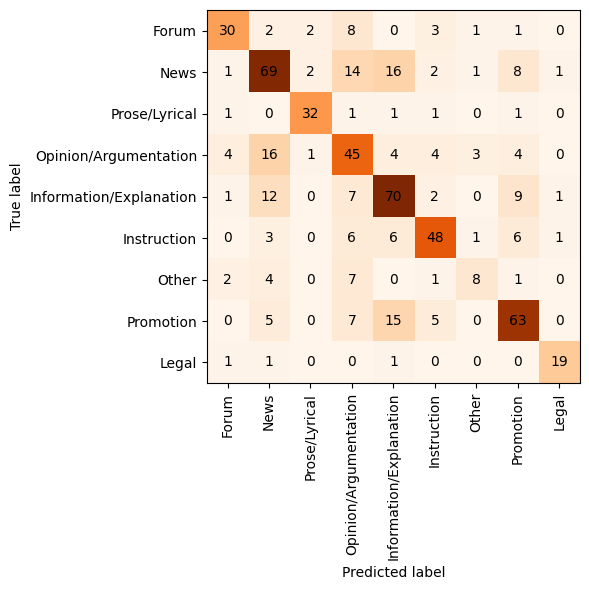

                         precision    recall  f1-score   support

                  Forum       0.75      0.64      0.69        47
                   News       0.62      0.69      0.65       102
          Prose/Lyrical       0.73      0.68      0.70        71
  Opinion/Argumentation       0.86      0.86      0.86        22
Information/Explanation       0.62      0.61      0.61       114
            Instruction       0.47      0.56      0.51        81
                  Other       0.57      0.35      0.43        23
              Promotion       0.68      0.66      0.67        95
                  Legal       0.86      0.86      0.86        37

               accuracy                           0.65       592
              macro avg       0.68      0.66      0.67       592
           weighted avg       0.65      0.65      0.65       592

Performance on X-GENRE (English part)
(413, 17)
Macro f1: 0.727, Micro f1: 0.707
Accuracy: 0.707


<Figure size 640x480 with 0 Axes>

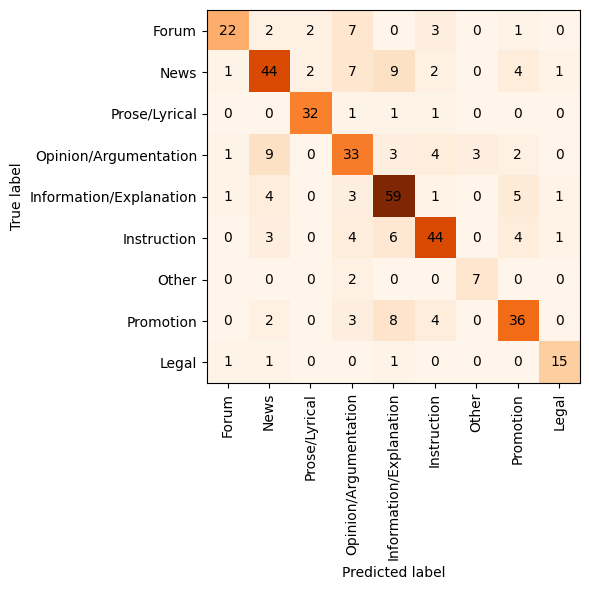

                         precision    recall  f1-score   support

                  Forum       0.85      0.59      0.70        37
                   News       0.68      0.80      0.73        74
          Prose/Lyrical       0.75      0.71      0.73        62
  Opinion/Argumentation       0.83      0.83      0.83        18
Information/Explanation       0.68      0.63      0.65        70
            Instruction       0.55      0.60      0.57        55
                  Other       0.70      0.78      0.74         9
              Promotion       0.69      0.68      0.69        53
                  Legal       0.89      0.91      0.90        35

               accuracy                           0.71       413
              macro avg       0.73      0.73      0.73       413
           weighted avg       0.71      0.71      0.71       413

Performance on X-GENRE (Slovene part)
(179, 17)
Macro f1: 0.475, Micro f1: 0.514
Accuracy: 0.514


<Figure size 640x480 with 0 Axes>

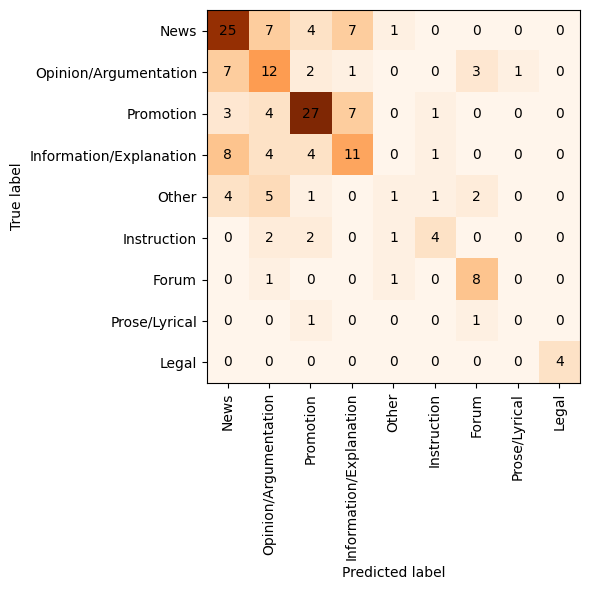

                         precision    recall  f1-score   support

                   News       0.57      0.80      0.67        10
  Opinion/Argumentation       0.42      0.39      0.41        28
              Promotion       0.57      0.44      0.50         9
Information/Explanation       1.00      1.00      1.00         4
                  Other       0.53      0.57      0.55        44
            Instruction       0.34      0.46      0.39        26
                  Forum       0.25      0.07      0.11        14
          Prose/Lyrical       0.66      0.64      0.65        42
                  Legal       0.00      0.00      0.00         2

               accuracy                           0.51       179
              macro avg       0.48      0.49      0.48       179
           weighted avg       0.50      0.51      0.50       179

svc
Performance on EN-GINCO
(272, 17)
Macro f1: 0.514, Micro f1: 0.489
Accuracy: 0.489


<Figure size 640x480 with 0 Axes>

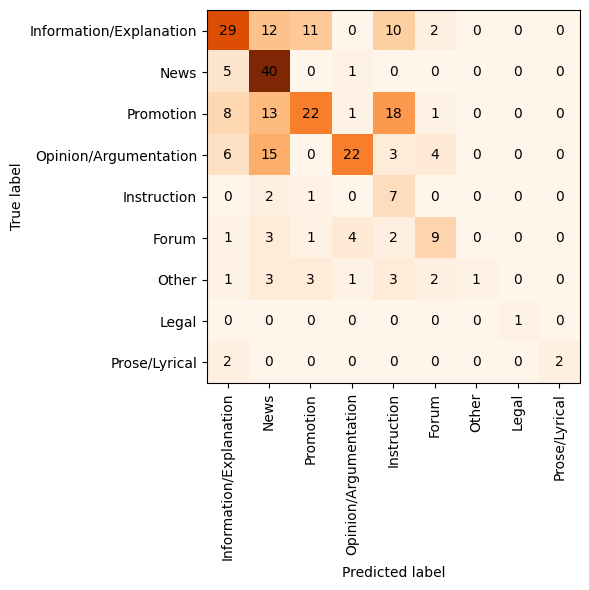

                         precision    recall  f1-score   support

Information/Explanation       0.50      0.45      0.47        20
                   News       0.56      0.45      0.50        64
              Promotion       0.16      0.70      0.26        10
  Opinion/Argumentation       1.00      1.00      1.00         1
            Instruction       0.45      0.87      0.60        46
                  Forum       0.76      0.44      0.56        50
                  Other       1.00      0.07      0.13        14
                  Legal       0.58      0.35      0.44        63
          Prose/Lyrical       1.00      0.50      0.67         4

               accuracy                           0.49       272
              macro avg       0.67      0.54      0.51       272
           weighted avg       0.59      0.49      0.49       272

Performance on X-GENRE (entire)
(592, 17)
Macro f1: 0.664, Micro f1: 0.657
Accuracy: 0.657


<Figure size 640x480 with 0 Axes>

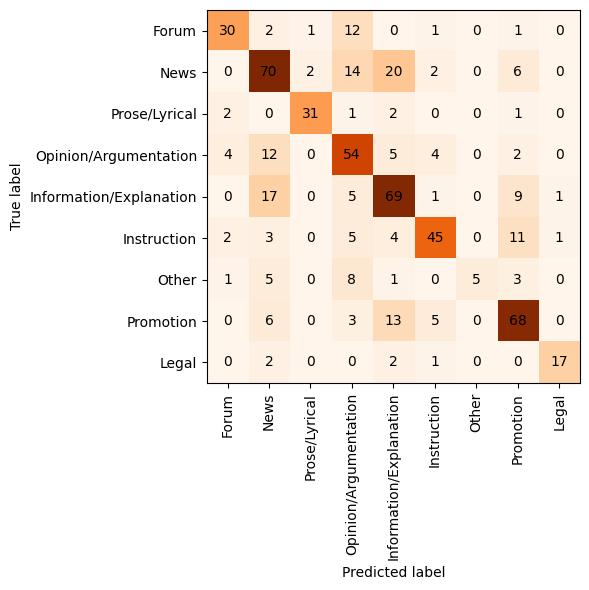

                         precision    recall  f1-score   support

                  Forum       0.77      0.64      0.70        47
                   News       0.59      0.68      0.63       102
          Prose/Lyrical       0.76      0.63      0.69        71
  Opinion/Argumentation       0.89      0.77      0.83        22
Information/Explanation       0.60      0.61      0.61       114
            Instruction       0.53      0.67      0.59        81
                  Other       1.00      0.22      0.36        23
              Promotion       0.67      0.72      0.69        95
                  Legal       0.91      0.84      0.87        37

               accuracy                           0.66       592
              macro avg       0.75      0.64      0.66       592
           weighted avg       0.68      0.66      0.66       592

Performance on X-GENRE (English part)
(413, 17)
Macro f1: 0.73, Micro f1: 0.709
Accuracy: 0.709


<Figure size 640x480 with 0 Axes>

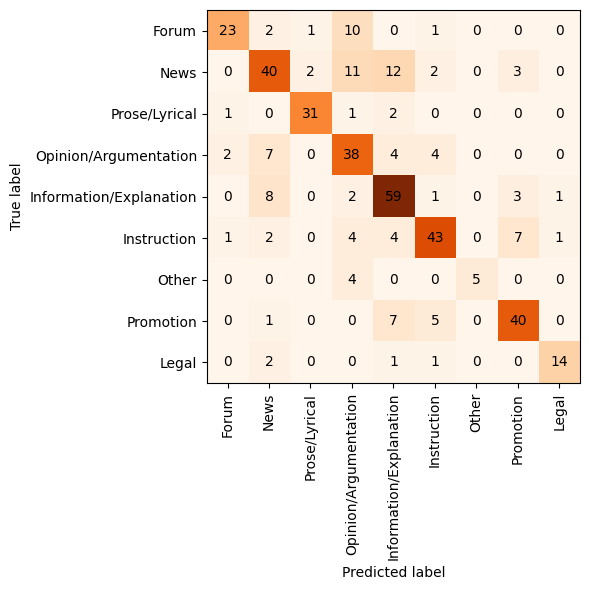

                         precision    recall  f1-score   support

                  Forum       0.85      0.62      0.72        37
                   News       0.66      0.80      0.72        74
          Prose/Lyrical       0.75      0.69      0.72        62
  Opinion/Argumentation       0.88      0.78      0.82        18
Information/Explanation       0.65      0.57      0.61        70
            Instruction       0.54      0.69      0.61        55
                  Other       1.00      0.56      0.71         9
              Promotion       0.75      0.75      0.75        53
                  Legal       0.91      0.89      0.90        35

               accuracy                           0.71       413
              macro avg       0.78      0.71      0.73       413
           weighted avg       0.72      0.71      0.71       413

Performance on X-GENRE (Slovene part)
(179, 17)
Macro f1: 0.445, Micro f1: 0.536
Accuracy: 0.536


<Figure size 640x480 with 0 Axes>

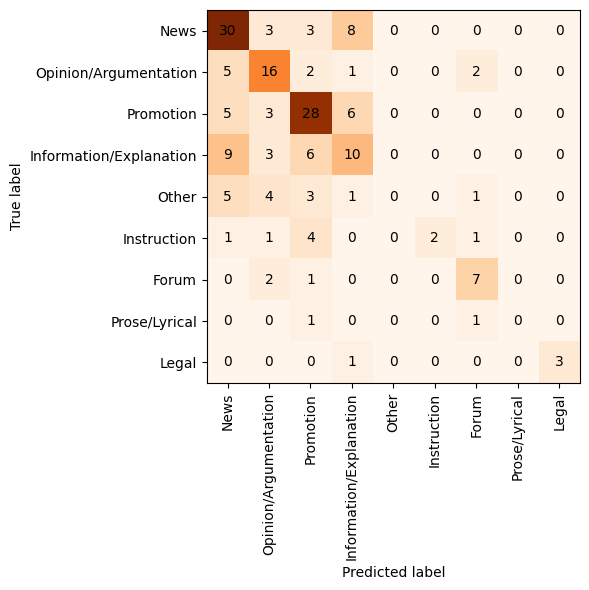

                         precision    recall  f1-score   support

                   News       0.58      0.70      0.64        10
  Opinion/Argumentation       0.37      0.36      0.36        28
              Promotion       1.00      0.22      0.36         9
Information/Explanation       1.00      0.75      0.86         4
                  Other       0.55      0.68      0.61        44
            Instruction       0.50      0.62      0.55        26
                  Forum       0.00      0.00      0.00        14
          Prose/Lyrical       0.58      0.67      0.62        42
                  Legal       0.00      0.00      0.00         2

               accuracy                           0.54       179
              macro avg       0.51      0.44      0.44       179
           weighted avg       0.51      0.54      0.50       179

FastText
Performance on EN-GINCO
(272, 17)
Macro f1: 0.411, Micro f1: 0.449
Accuracy: 0.449


/home/tajak/Classification-with-ChatGPT/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/Classification-with-ChatGPT/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/Classification-with-ChatGPT/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

<Figure size 640x480 with 0 Axes>

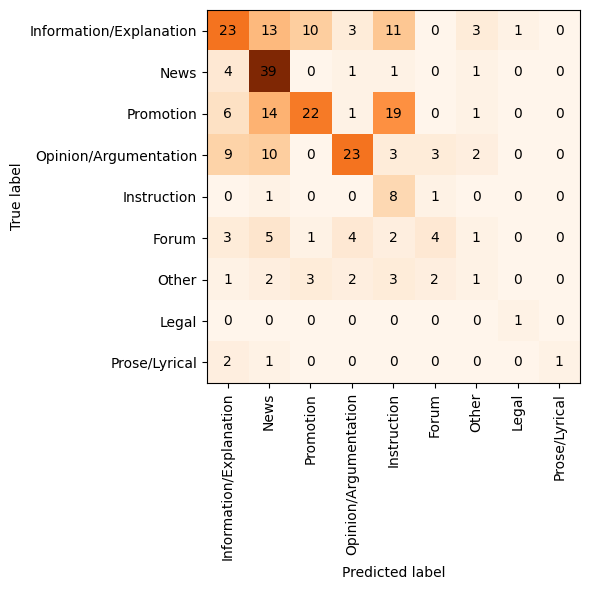

                         precision    recall  f1-score   support

Information/Explanation       0.40      0.20      0.27        20
                   News       0.48      0.36      0.41        64
              Promotion       0.17      0.80      0.28        10
  Opinion/Argumentation       0.50      1.00      0.67         1
            Instruction       0.46      0.85      0.60        46
                  Forum       0.68      0.46      0.55        50
                  Other       0.11      0.07      0.09        14
                  Legal       0.61      0.35      0.44        63
          Prose/Lyrical       1.00      0.25      0.40         4

               accuracy                           0.45       272
              macro avg       0.49      0.48      0.41       272
           weighted avg       0.51      0.45      0.44       272

Performance on X-GENRE (entire)
(592, 17)
Macro f1: 0.636, Micro f1: 0.639
Accuracy: 0.639


<Figure size 640x480 with 0 Axes>

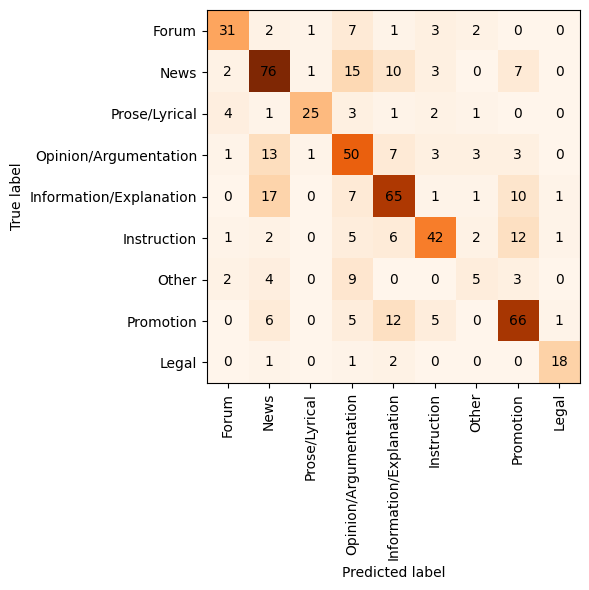

                         precision    recall  f1-score   support

                  Forum       0.76      0.66      0.70        47
                   News       0.62      0.64      0.63       102
          Prose/Lyrical       0.71      0.59      0.65        71
  Opinion/Argumentation       0.86      0.82      0.84        22
Information/Explanation       0.62      0.67      0.64       114
            Instruction       0.49      0.62      0.55        81
                  Other       0.36      0.22      0.27        23
              Promotion       0.65      0.69      0.67        95
                  Legal       0.89      0.68      0.77        37

               accuracy                           0.64       592
              macro avg       0.66      0.62      0.64       592
           weighted avg       0.65      0.64      0.64       592

Performance on X-GENRE (English part)
(413, 17)
Macro f1: 0.679, Micro f1: 0.676
Accuracy: 0.676


<Figure size 640x480 with 0 Axes>

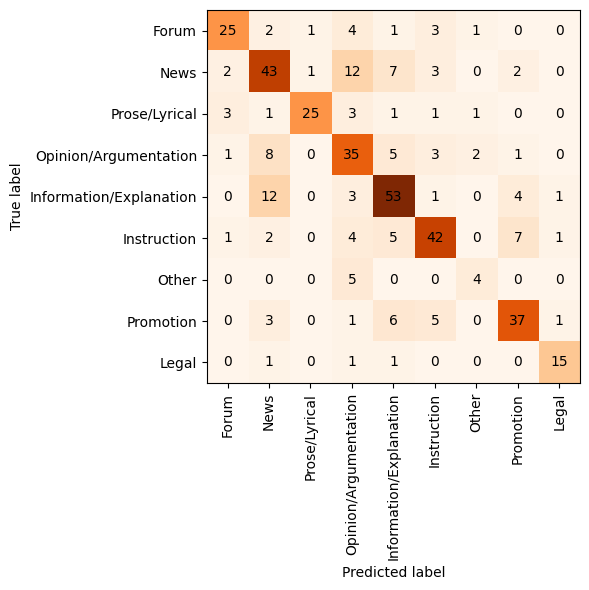

                         precision    recall  f1-score   support

                  Forum       0.78      0.68      0.72        37
                   News       0.67      0.72      0.69        74
          Prose/Lyrical       0.72      0.68      0.70        62
  Opinion/Argumentation       0.83      0.83      0.83        18
Information/Explanation       0.60      0.61      0.61        70
            Instruction       0.51      0.64      0.57        55
                  Other       0.50      0.44      0.47         9
              Promotion       0.73      0.70      0.71        53
                  Legal       0.93      0.71      0.81        35

               accuracy                           0.68       413
              macro avg       0.70      0.67      0.68       413
           weighted avg       0.69      0.68      0.68       413

Performance on X-GENRE (Slovene part)
(179, 17)
Macro f1: 0.43, Micro f1: 0.553
Accuracy: 0.553


<Figure size 640x480 with 0 Axes>

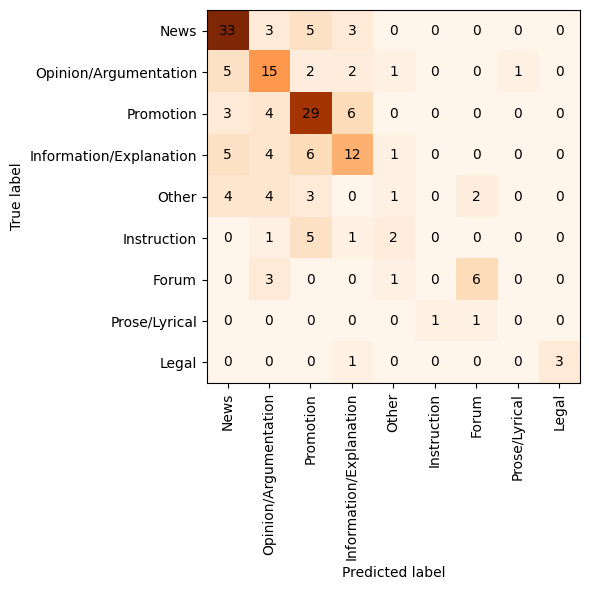

                         precision    recall  f1-score   support

                   News       0.67      0.60      0.63        10
  Opinion/Argumentation       0.48      0.43      0.45        28
              Promotion       0.00      0.00      0.00         9
Information/Explanation       1.00      0.75      0.86         4
                  Other       0.66      0.75      0.70        44
            Instruction       0.44      0.58      0.50        26
                  Forum       0.17      0.07      0.10        14
          Prose/Lyrical       0.58      0.69      0.63        42
                  Legal       0.00      0.00      0.00         2

               accuracy                           0.55       179
              macro avg       0.44      0.43      0.43       179
           weighted avg       0.51      0.55      0.53       179

X-GENRE
Performance on EN-GINCO
(272, 17)
Macro f1: 0.686, Micro f1: 0.684
Accuracy: 0.684


<Figure size 640x480 with 0 Axes>

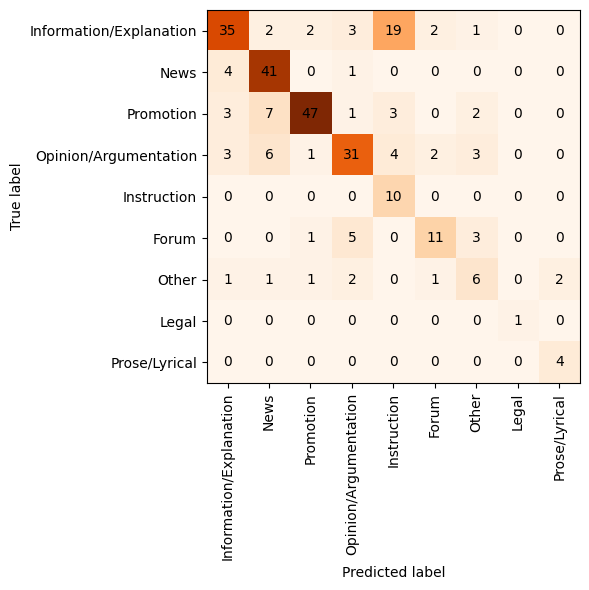

                         precision    recall  f1-score   support

Information/Explanation       0.69      0.55      0.61        20
                   News       0.76      0.55      0.64        64
              Promotion       0.28      1.00      0.43        10
  Opinion/Argumentation       1.00      1.00      1.00         1
            Instruction       0.72      0.89      0.80        46
                  Forum       0.72      0.62      0.67        50
                  Other       0.40      0.43      0.41        14
                  Legal       0.90      0.75      0.82        63
          Prose/Lyrical       0.67      1.00      0.80         4

               accuracy                           0.68       272
              macro avg       0.68      0.75      0.69       272
           weighted avg       0.74      0.68      0.69       272

Performance on X-GENRE (entire)
(592, 17)
Macro f1: 0.794, Micro f1: 0.797
Accuracy: 0.797


<Figure size 640x480 with 0 Axes>

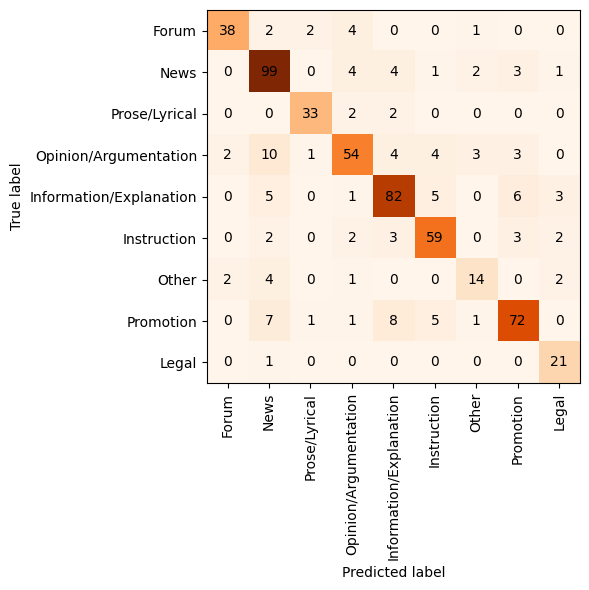

                         precision    recall  f1-score   support

                  Forum       0.90      0.81      0.85        47
                   News       0.80      0.80      0.80       102
          Prose/Lyrical       0.80      0.83      0.81        71
  Opinion/Argumentation       0.72      0.95      0.82        22
Information/Explanation       0.76      0.87      0.81       114
            Instruction       0.78      0.67      0.72        81
                  Other       0.67      0.61      0.64        23
              Promotion       0.83      0.76      0.79        95
                  Legal       0.89      0.89      0.89        37

               accuracy                           0.80       592
              macro avg       0.79      0.80      0.79       592
           weighted avg       0.80      0.80      0.80       592

Performance on X-GENRE (English part)
(413, 17)
Macro f1: 0.83, Micro f1: 0.818
Accuracy: 0.818


<Figure size 640x480 with 0 Axes>

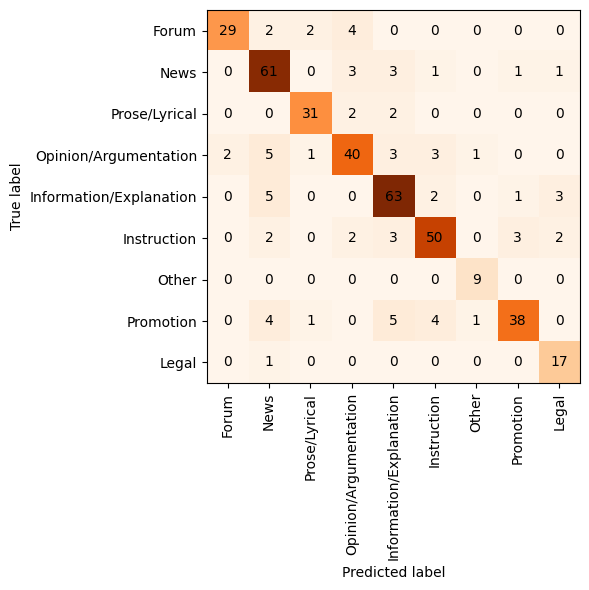

                         precision    recall  f1-score   support

                  Forum       0.94      0.78      0.85        37
                   News       0.80      0.85      0.82        74
          Prose/Lyrical       0.83      0.81      0.82        62
  Opinion/Argumentation       0.74      0.94      0.83        18
Information/Explanation       0.76      0.87      0.81        70
            Instruction       0.78      0.73      0.75        55
                  Other       0.82      1.00      0.90         9
              Promotion       0.88      0.72      0.79        53
                  Legal       0.89      0.89      0.89        35

               accuracy                           0.82       413
              macro avg       0.83      0.84      0.83       413
           weighted avg       0.82      0.82      0.82       413

Performance on X-GENRE (Slovene part)
(179, 17)
Macro f1: 0.758, Micro f1: 0.749
Accuracy: 0.749


<Figure size 640x480 with 0 Axes>

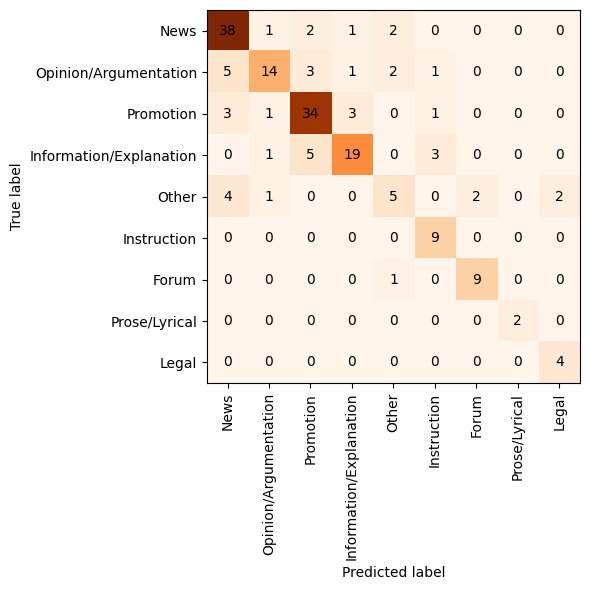

                         precision    recall  f1-score   support

                   News       0.82      0.90      0.86        10
  Opinion/Argumentation       0.79      0.68      0.73        28
              Promotion       0.64      1.00      0.78         9
Information/Explanation       0.67      1.00      0.80         4
                  Other       0.76      0.86      0.81        44
            Instruction       0.78      0.54      0.64        26
                  Forum       0.50      0.36      0.42        14
          Prose/Lyrical       0.77      0.81      0.79        42
                  Legal       1.00      1.00      1.00         2

               accuracy                           0.75       179
              macro avg       0.75      0.79      0.76       179
           weighted avg       0.75      0.75      0.74       179



<Figure size 640x480 with 0 Axes>

In [7]:
for model in ['dummy-classifier-stratified', 'nb-complement', 'logistic-regression','svc', "FastText", "X-GENRE"]:
    print(model)
    result = test_splits(model)
    en_ginco_all_results[model] = result["en-ginco"]
    x_genre_all_results[model] = result["x-genre"]
    x_genre_en_all_results[model] = result["x-genre-en"]
    x_genre_sl_all_results[model] = result["x-genre-sl"]

In [8]:
en_ginco_res_df = pd.DataFrame(en_ginco_all_results).T[["micro F1", "macro F1", "accuracy"]].sort_values("macro F1", ascending=False).round(2)
en_ginco_res_df

,micro F1,macro F1,accuracy
X-GENRE,0.68,0.69,0.68
svc,0.49,0.51,0.49
logistic-regression,0.49,0.47,0.49
FastText,0.45,0.41,0.45
nb-complement,0.36,0.29,0.36
dummy-classifier-stratified,0.14,0.10,0.14


In [10]:
print(en_ginco_res_df.to_markdown())

|                             |   micro F1 |   macro F1 |   accuracy |
|:----------------------------|-----------:|-----------:|-----------:|
| X-GENRE                     |       0.68 |       0.69 |       0.68 |
| svc                         |       0.49 |       0.51 |       0.49 |
| logistic-regression         |       0.49 |       0.47 |       0.49 |
| FastText                    |       0.45 |       0.41 |       0.45 |
| nb-complement               |       0.36 |       0.29 |       0.36 |
| dummy-classifier-stratified |       0.14 |       0.1  |       0.14 |


In [15]:
x_genre_res_df = pd.DataFrame(x_genre_all_results).T[["micro F1", "macro F1", "accuracy"]].sort_values("macro F1", ascending=False).round(2)
x_genre_res_df

,micro F1,macro F1,accuracy
X-GENRE,0.80,0.79,0.80
logistic-regression,0.65,0.67,0.65
svc,0.66,0.66,0.66
FastText,0.64,0.64,0.64
nb-complement,0.56,0.52,0.56
dummy-classifier-stratified,0.13,0.09,0.13


In [16]:
print(x_genre_res_df.to_markdown())

|                             |   micro F1 |   macro F1 |   accuracy |
|:----------------------------|-----------:|-----------:|-----------:|
| X-GENRE                     |       0.8  |       0.79 |       0.8  |
| logistic-regression         |       0.65 |       0.67 |       0.65 |
| svc                         |       0.66 |       0.66 |       0.66 |
| FastText                    |       0.64 |       0.64 |       0.64 |
| nb-complement               |       0.56 |       0.52 |       0.56 |
| dummy-classifier-stratified |       0.13 |       0.09 |       0.13 |


In [17]:
x_genre_en_res_df = pd.DataFrame(x_genre_en_all_results).T[["micro F1", "macro F1", "accuracy"]].sort_values("macro F1", ascending=False).round(2)
x_genre_en_res_df

,micro F1,macro F1,accuracy
X-GENRE,0.82,0.83,0.82
svc,0.71,0.73,0.71
logistic-regression,0.71,0.73,0.71
FastText,0.68,0.68,0.68
nb-complement,0.60,0.54,0.60
dummy-classifier-stratified,0.13,0.10,0.13


In [18]:
print(x_genre_en_res_df.to_markdown())

|                             |   micro F1 |   macro F1 |   accuracy |
|:----------------------------|-----------:|-----------:|-----------:|
| X-GENRE                     |       0.82 |       0.83 |       0.82 |
| svc                         |       0.71 |       0.73 |       0.71 |
| logistic-regression         |       0.71 |       0.73 |       0.71 |
| FastText                    |       0.68 |       0.68 |       0.68 |
| nb-complement               |       0.6  |       0.54 |       0.6  |
| dummy-classifier-stratified |       0.13 |       0.1  |       0.13 |


In [20]:
x_genre_sl_res_df = pd.DataFrame(x_genre_sl_all_results).T[["micro F1", "macro F1", "accuracy"]].sort_values("macro F1", ascending=False).round(2)
x_genre_sl_res_df

,micro F1,macro F1,accuracy
X-GENRE,0.75,0.76,0.75
logistic-regression,0.51,0.48,0.51
svc,0.54,0.44,0.54
FastText,0.55,0.43,0.55
nb-complement,0.46,0.18,0.46
dummy-classifier-stratified,0.12,0.08,0.12


In [21]:
print(x_genre_sl_res_df.to_markdown())

|                             |   micro F1 |   macro F1 |   accuracy |
|:----------------------------|-----------:|-----------:|-----------:|
| X-GENRE                     |       0.75 |       0.76 |       0.75 |
| logistic-regression         |       0.51 |       0.48 |       0.51 |
| svc                         |       0.54 |       0.44 |       0.54 |
| FastText                    |       0.55 |       0.43 |       0.55 |
| nb-complement               |       0.46 |       0.18 |       0.46 |
| dummy-classifier-stratified |       0.12 |       0.08 |       0.12 |


In [33]:
df_test.head(1)

,text,true_label,id,dataset,truncated_texts,true_label_forChatGPT,gpt-3.5-turbo,mt0,text_prompts,mt0_xl,X-GENRE,X-GENRE-confidence,dummy-classifier-stratified,nb-complement,logistic-regression,svc,FastText
0,Welcome to KBismarck.org! This is a community ...,Information/Explanation,en_ginco_0,EN-GINCO,Welcome to KBismarck.org! This is a community ...,Information,Forum,Forum,Please classify the following text according t...,Forum,Forum,"[('Forum', 0.9329903455731817), ('Other', 0.05...",Information/Explanation,Instruction,Opinion/Argumentation,Promotion,Promotion


In [34]:
# Save the results in a csv format
df_test.to_csv("data/main_test_file_with_predictions-additional-baseline-classifiers.csv")